In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def enhance_and_sharpen_image(img):
    """
    Enhance the image by applying sharpening and histogram equalization.
    """
    # Convert to LAB color space for better contrast adjustment
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge the LAB channels back and convert to BGR
    enhanced_img = cv2.merge((l, a, b))
    enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_LAB2BGR)

    # Sharpen the image using a kernel
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened_img = cv2.filter2D(enhanced_img, -1, sharpening_kernel)

    return sharpened_img

In [ ]:
def doc_scanner(image_path):
    """
    Function to extract out the document part only.
    """
    img = cv2.imread(image_path)

    # Enhance and sharpen the image
    enhanced_img = enhance_and_sharpen_image(img)

    # Convert to grayscale
    gray = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (15, 15), 2)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Morphological operations to clean up the edges
    kernel = np.ones((5, 5), np.uint8)
    edges_cleaned = cv2.dilate(edges, kernel, iterations=1)
    edges_cleaned = cv2.erode(edges_cleaned, kernel, iterations=1)

    # Find contours
    contours, _ = cv2.findContours(edges_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to a polygon
    peri = cv2.arcLength(largest_contour, True)
    approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)

    # Ensure we have at least 4 points for perspective transformation
    if len(approx) == 4:
        # Sort the points (Top-left, Top-right, Bottom-right, Bottom-left)
        pts = approx.reshape(-1, 2)
        rect = np.zeros((4, 2), dtype="float32")

        # Top-left: smallest sum, Bottom-right: largest sum
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]  # Top-left
        rect[2] = pts[np.argmax(s)]  # Bottom-right

        # Top-right: smallest diff, Bottom-left: largest diff
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]  # Top-right
        rect[3] = pts[np.argmax(diff)]  # Bottom-left

        # Define the destination points for the perspective transform
        (tl, tr, br, bl) = rect

        width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
        height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))
        dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype="float32")

        # Compute the perspective transform matrix and apply it
        M = cv2.getPerspectiveTransform(rect, dst)
        warped = cv2.warpPerspective(img, M, (width, height))

        # Save the warped image
        cv2.imwrite('warped_image.jpg', warped)
        print("Warped image saved as 'warped_image.jpg'")
    else:
        print("Could not find sufficient corners. Perspective correction skipped.")
        warped = None

    # Plot all preprocessing steps
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
    plt.title("Enhanced and Sharpened Image")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred Image")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(edges, cmap='gray')
    plt.title("Edges Detected")
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(edges_cleaned, cmap='gray')
    plt.title("Cleaned Edges")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    img_contours = img.copy()
    cv2.drawContours(img_contours, [largest_contour], -1, (0, 255, 0), 3)
    plt.imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    plt.title("Largest Contour Highlighted")
    plt.axis('off')

    # Warped image (if successful)
    if warped is not None:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        plt.title("Warped (Perspective Corrected)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Warped image saved as 'warped_image.jpg'


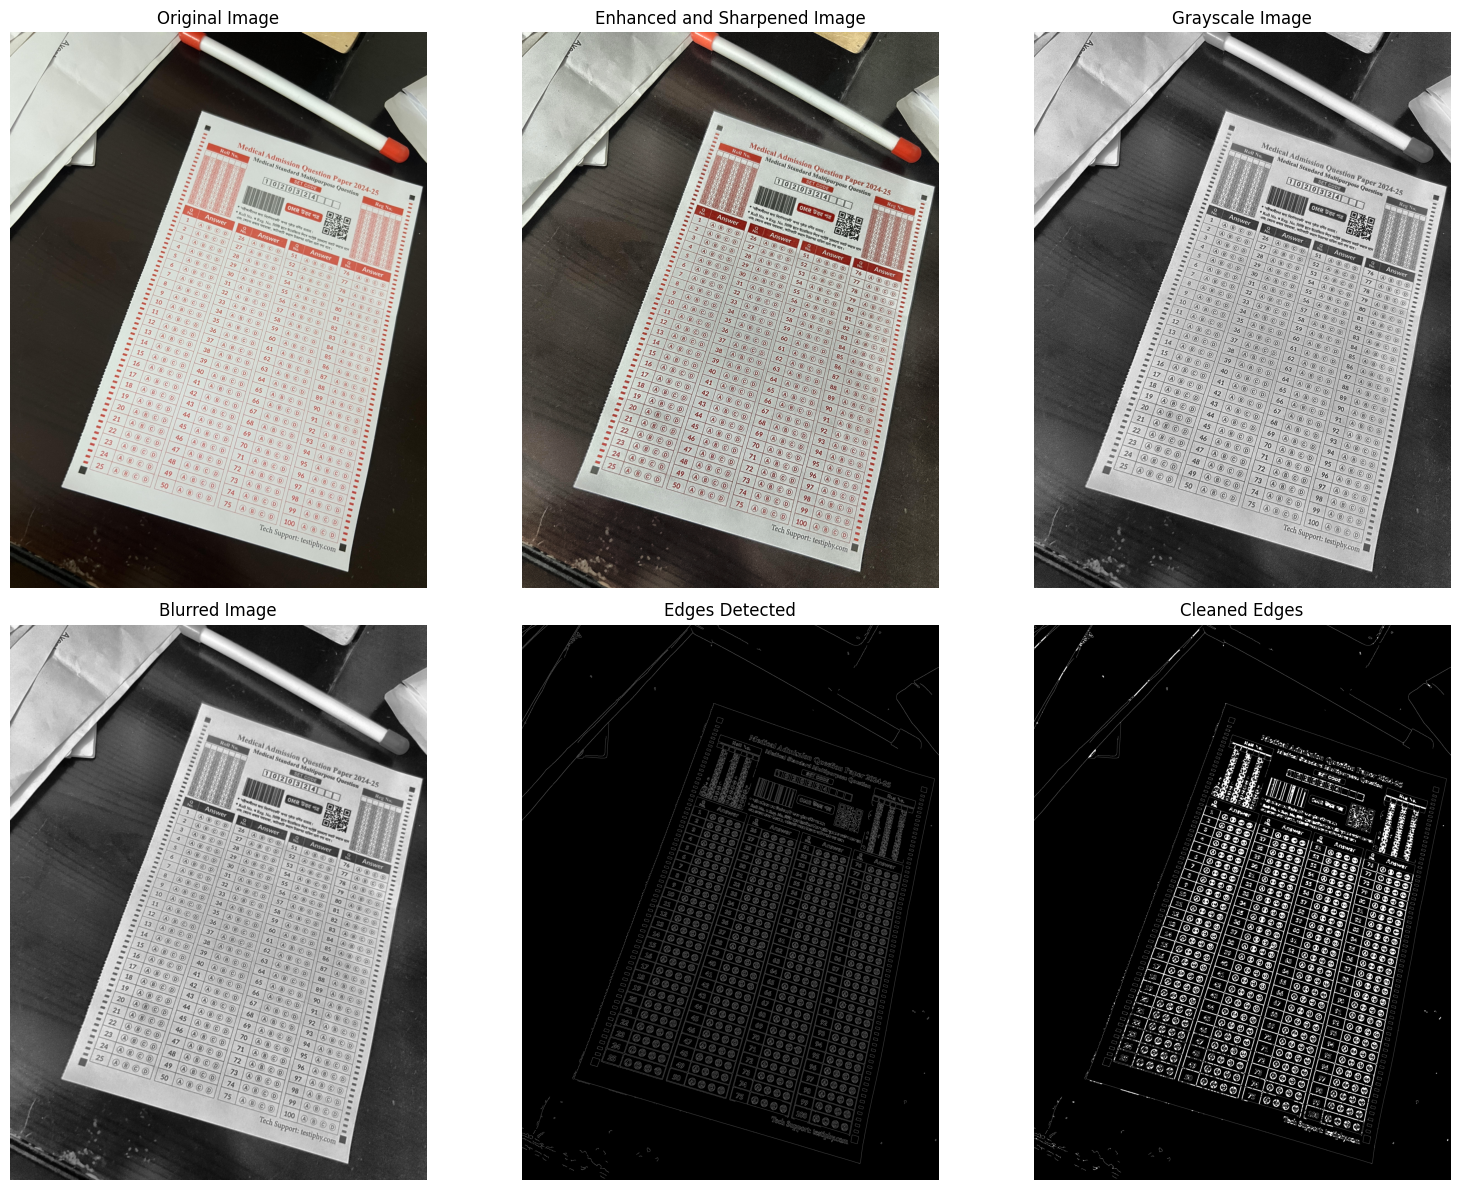

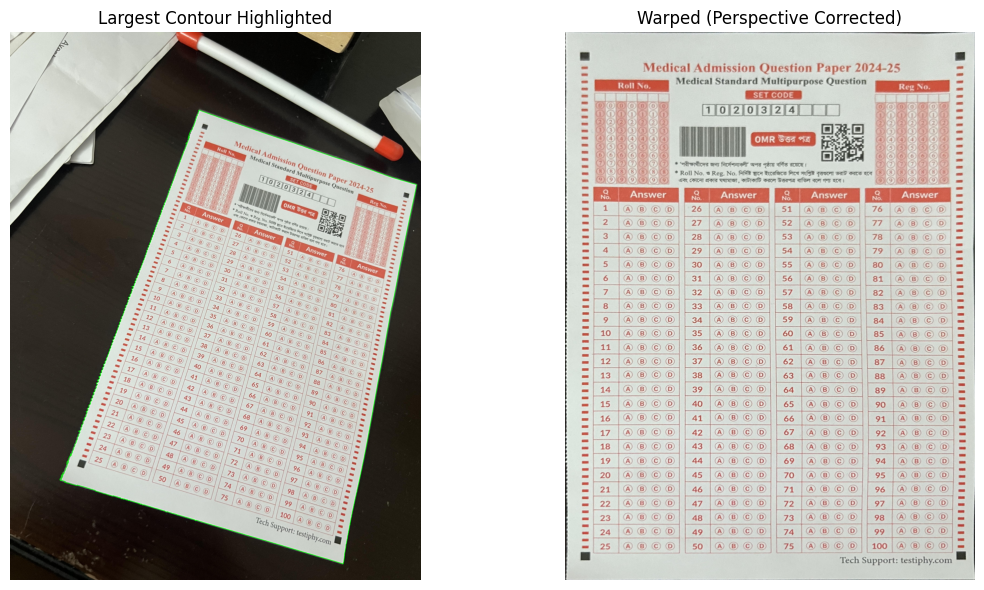

In [ ]:
doc_scanner('raw_image.jpg')

In [ ]:
def detect_bubbles(image):
    """
    Function to detect bubbles in the given image using Hough Circle Transform.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply adaptive thresholding to enhance bubble edges
    thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    # Perform Hough Circle Transform (Detecting "bubbles")
    circles = cv2.HoughCircles(
        thresh, 
        cv2.HOUGH_GRADIENT, 
        dp=1.2,
        minDist=30,
        param1=50,
        param2=40,
        minRadius=15,  
        maxRadius=30
    )

    # Draw detected bubbles on the image
    result_img = image.copy()
    bubble_count = 0
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        bubble_count = len(circles)
        for (x, y, r) in circles:
            # Draw the bubble
            cv2.circle(result_img, (x, y), r, (0, 255, 0), 3)
            # Draw the center of the bubble
            # cv2.circle(result_img, (x, y), 2, (255, 0, 0), 3)

    return result_img, bubble_count, gray, blurred, thresh

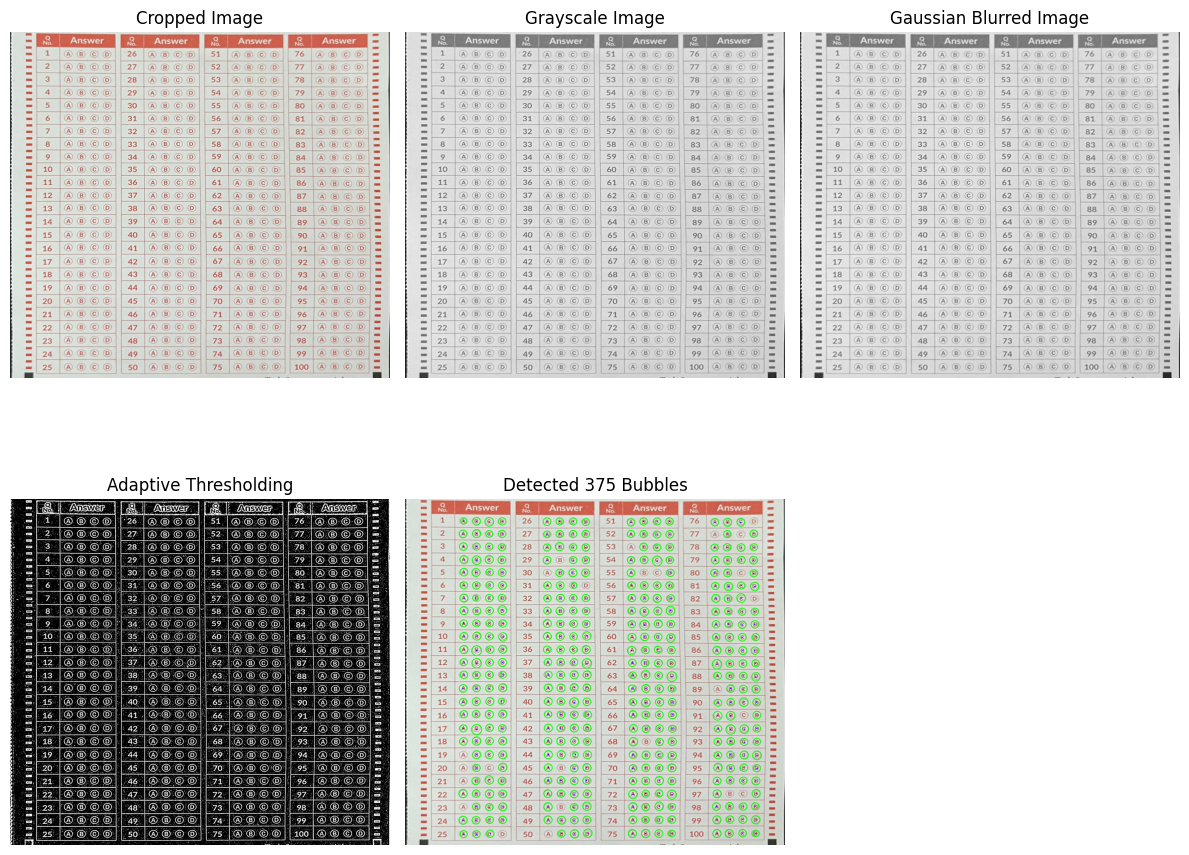

Image with detected bubbles saved as 'bubble_detected_image.jpg'. Total bubbles detected: 375


In [ ]:
image_path = 'warped_image.jpg'
enhanced_img = cv2.imread(image_path)

if enhanced_img is not None:
    # Cropping upper and lower portions
    height, width, _ = enhanced_img.shape
    upper_crop_ratio = 0.28
    lower_crop_ratio = 0.04

    upper_crop = int(height * upper_crop_ratio)
    lower_crop = int(height * (1 - lower_crop_ratio))
    cropped_img = enhanced_img[upper_crop:lower_crop, :]

    # Detect bubbles in the cropped image
    result_image, bubble_count, gray, blurred, thresh = detect_bubbles(cropped_img)

    # Plotting the preprocessing steps and results
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Image")
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(blurred, cmap='gray')
    plt.title("Gaussian Blurred Image")
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(thresh, cmap='gray')
    plt.title("Adaptive Thresholding")
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected {bubble_count} Bubbles")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    cv2.imwrite('bubble_detected_image.jpg', result_image)
    print(f"Image with detected bubbles saved as 'bubble_detected_image.jpg'. Total bubbles detected: {bubble_count}")
else:
    print("Image not found. Please check the path.")


In [ ]:
def calculate_accuracy(detected_bubbles, total_bubbles):
    """
    Function to calculate accuracy based on the number of detected bubbles and the total bubbles.
    """
    accuracy = (detected_bubbles / total_bubbles) * 100
    return accuracy

total_bubbles = 400

accuracy = calculate_accuracy(bubble_count, total_bubbles)

print(f"Accuracy of bubble detection: {accuracy:.2f}%")

Accuracy of bubble detection: 93.75%
